In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.memory_stats.python.ops.memory_stats_ops import BytesInUse

import itertools

import pandas as pd

# sorting results
from collections import defaultdict
from operator import itemgetter
import timeit #measure runtime
import random #masking
import multiprocessing
import operator
from functools import partial
import allel
from scipy.spatial.distance import squareform

In [11]:
def process_data(posfile, infile, categorical="False"):
    
    start = timeit.default_timer()
    
    #Header and column names start with hastag, skip those
    #posfile should contain 2 columns separated by tab: 1st = chromosome ID, 2nd = position
    #vcf can be imported as posfile as well, but will take much longer to read and process
    refpos = pd.read_csv(posfile, sep='\t', comment='#',header=None)
    
    #0      22065657
    #1      22065697
    #2      22065904
    #3      22065908
    #4      22065974
    #5      22065977
    
    refpos = pd.Series(refpos[1], index=range(len(refpos[1])))

    #print(refpos[1])
    
    #infile is the input file: genotype data set to be imputed
    df = pd.read_csv(infile, sep='\t', comment='#',header=None)
    
    #0      22065657
    #1      22066211
    #2      22066363
    #3      22066572
    #4      22067004
    #5      22067276
    
    inpos = pd.Series(range(len(df[1])), index=df[1])
    
    #print(inpos[2])
    
    #genetic variants are rows and samples are columns
    #let's transpose so the variants become columns and samples are rows
    df_T = df.transpose()
    
    new_df = 0
    
    if(categorical=="False"):
        new_df = np.zeros((len(df_T)-9,len(refpos),2)) #subjects, variants, Allele counts
    else:
        new_df = np.zeros((len(df_T)-9,len(refpos)))  #subjects, variants
    #print(new_df.shape)
    i = 9 #RR column index
    j = 0 #RR row index
    idx = 0
    print("Processing input data.")
    #print(categorical)
    myidx = 0
    
    while i < len(df_T):
        j = 0
        while j < len(refpos): #"|" is present when phased data is proved, "/" is usually unphased
            if(refpos[j] in inpos.keys()):
                myidx = inpos[refpos[j]]
                #print(j)
                #print(inpos[refpos[j]])
                #print(refpos[j])
                #print(df[i][myidx])
                #print(df[i+1][myidx])
                if(df[i][myidx].startswith('1|1') or df[i][myidx].startswith('1/1')):
                    if(categorical=="True"):
                        new_df[idx][j] = 2
                    else:
                        #new_df[idx][j] = np.array([0,2])
                        new_df[idx][j][0] = 0
                        new_df[idx][j][1] = 2
                elif(df[i][myidx].startswith('1|0') or df[i][myidx].startswith('0|1') or df[i][myidx].startswith('1/0') or df[i][myidx].startswith('0/1')):
                    if(categorical=="True"):
                        new_df[idx][j] = 1
                    else:
                        #new_df[idx][j] = np.array([1,1])
                        new_df[idx][j][0] = 1
                        new_df[idx][j][1] = 1
                elif(df[i][myidx].startswith('0|0') or df[i][myidx].startswith('0/0')):
                    if(categorical=="True"): 
                        new_df[idx][j] = 0
                    else:
                        #new_df[idx][j] = np.array([2,0])
                        new_df[idx][j][0] = 2
                        new_df[idx][j][1] = 0
                else:
                    if(categorical=="True"):
                        new_df[idx][j] = -1
                    else:
                        #new_df[idx][j] = np.array([0,0]) 
                        new_df[idx][j][0] = 0 
                        new_df[idx][j][1] = 0 
            else:
                if(categorical=="True"):
                    new_df[idx][j] = -1
                else:
                    #new_df[idx][j] = np.array([0,0]) 
                    new_df[idx][j][0] = 0 
                    new_df[idx][j][1] = 0 
                #if(idx==0):
                #    print(j)
                #RR I forgot to mention that we have to take into account possible missing data
                #RR in case there is missing data (NA, .|., -|-, or anything different from 0|0, 1|1, 0|1, 1|0) = 3
            j += 1
        i += 1
        #pbar.update(1)
        idx += 1

    #print("processed_data")
    #for i in range(10):
    #    print(new_df[i][0])

    #the data needs to be flattened because the matrix multiplication step (x*W) 
    #doesn't support features with subfeatures (matrix of vectors)
    #new_df = np.reshape(new_df, (new_df.shape[0],new_df.shape[1]*2))
    #print(new_df.shape)
    #pbar.close()
    stop = timeit.default_timer()
    print('Time to load the data (sec): ', stop - start)
    
    return new_df


In [12]:
def calculate_MAF_global(indexes, inx, categorical="False"):
    j=0
    if(do_parallel_MAF==True):
        getter = operator.itemgetter(indexes)
        x = list(map(list, map(getter, np.copy(inx))))
    else:
        x = inx
    MAF_list = []
    #print("LENGTH", len(x[0]))
    if(categorical=="True" or categorical==True):
        while j < (len(x[0])):
            ref = 0
            alt = 0
            MAF = 0        
            for i in range(len(x)):
                if(i == 0):
                    ref+=2
                elif(i == 1):
                    ref+=1
                    alt+=1
                elif(i == 2):
                    alt+=2
            if(alt<=ref):
                MAF=alt/(ref+alt)
                #major=ref/len(y)
            else:
                MAF=ref/(ref+alt)
                #major=alt/len(y)
                #print(MAF)
            MAF_list.append(MAF)    
            j+=1          
    elif(categorical=="False" or categorical==False):
        while j < (len(x[0])):
            ref = 0
            alt = 0
            MAF = 0        
            for i in range(len(x)):
                ref+=x[i][j][0]
                alt+=x[i][j][1]   
            if(alt<=ref):
                MAF=alt/(ref+alt)
                #major=ref/len(y)
            else:
                MAF=ref/(ref+alt)
            MAF_list.append(MAF)    
            j+=1
    return MAF_list

In [13]:
def mask_data(mydata, mask_rate=0.9, categorical="False"):
    start = timeit.default_timer()
    # random matrix the same shape of your data
    #print(len(mydata))
    nmask = int(round(len(mydata[0])*mask_rate))
    # random boolean mask for which values will be changed
    maskindex = random.sample(range(0, len(mydata[0]-1)), nmask)
    maskindex = [211, 654, 274, 410, 236, 731, 678, 490, 710, 650, 377, 826, 483, 828, 283, 237, 625, 844, 796, 428, 235, 238, 185, 790, 630, 89, 51, 760, 134, 421, 217, 138, 513, 116, 824, 623, 266, 142, 286, 158, 485, 309, 794, 546, 203, 809, 333, 593, 258, 172, 605, 293, 466, 693, 97, 234, 326, 764, 628, 372, 426, 46, 52, 752, 680, 493, 798, 507, 98, 243, 87, 31, 477, 510, 28, 264, 606, 166, 154, 63, 374, 547, 57, 91, 543, 818, 363, 122, 218, 219, 365, 624, 703, 821, 707, 191, 423, 61, 399, 738, 222, 540, 685, 801, 737, 104, 587, 793, 661, 486, 782, 37, 516, 772, 814, 305, 588, 103, 859, 762, 22, 567, 487, 223, 658, 541, 523, 33, 296, 465, 130, 626, 361, 761, 419, 111, 226, 622, 402, 163, 132, 691, 39, 648, 495, 287, 492, 40, 190, 501, 520, 827, 231, 770, 713, 659, 702, 340, 517, 24, 277, 749, 221, 524, 167, 504, 126, 531, 617, 527, 371, 742, 108, 719, 164, 392, 739, 602, 298, 41, 640, 674, 313, 646, 422, 566, 594, 290, 383, 187, 837, 112, 450, 603, 457, 805, 500, 148, 629, 225, 389, 21, 591, 627, 378, 3, 512, 449, 570, 140, 855, 263, 468, 143, 322, 544, 604, 451, 754, 242, 95, 10, 413, 49, 864, 347, 461, 141, 375, 689, 692, 706, 345, 542, 849, 145, 107, 803, 584, 780, 632, 385, 579, 503, 69, 415, 788, 81, 330, 643, 559, 56, 284, 438, 571, 718, 241, 34, 316, 532, 817, 775, 665, 58, 511, 787, 268, 536, 147, 379, 533, 637, 740, 14, 783, 118, 171, 168, 366, 84, 842, 853, 357, 319, 292, 88, 406, 324, 829, 765, 489, 408, 435, 444, 156, 215, 109, 644, 808, 607, 744, 663, 845, 4, 12, 220, 865, 356, 331, 418, 813, 315, 447, 454, 539, 779, 170, 251, 83, 631, 189, 73, 262, 105, 858, 615, 188, 353, 301, 581, 700, 350, 456, 730, 555, 664, 196, 70, 458, 529, 723, 725, 840, 32, 247, 60, 306, 439, 38, 573, 834, 822, 387, 48, 701, 216, 564, 810, 317, 442, 54, 327, 437, 254, 386, 240, 230, 734, 590, 151, 136, 472, 328, 836, 611, 515, 820, 460, 250, 589, 425, 5, 786, 497, 655, 666, 568, 657, 535, 561, 233, 835, 71, 125, 756, 131, 769, 161, 578, 862, 577, 653, 123, 720, 272, 181, 528, 552, 178, 807, 208, 152, 96, 434, 209, 785, 621, 619, 176, 462, 295, 610, 649, 745, 232, 514, 861, 667, 239, 229, 433, 260, 159, 113, 481, 360, 35, 436, 494, 397, 11, 416, 797, 72, 25, 213, 595, 320, 198, 348, 560, 395, 153, 771, 727, 318, 66, 139, 92, 99, 694, 411, 179, 502, 304, 804, 120, 252, 101, 750, 403, 9, 204, 480, 741, 811, 42, 592, 129, 598, 599, 124, 843, 329, 574, 224, 19, 420, 396, 310, 43, 370, 812, 792, 777, 521, 846, 635, 115, 393, 645, 609, 368, 616, 519, 160, 755, 380, 362, 711, 94, 311, 746, 409, 802, 776, 312, 68, 400, 816, 735, 668, 280, 373, 67, 30, 612, 660, 302, 509, 259, 173, 841, 390, 582, 79, 369, 200, 192, 26, 681, 733, 384, 526, 597, 585, 795, 246, 647, 554, 271, 833, 55, 257, 850, 478, 565, 417, 498, 269, 430, 613, 401, 128, 227, 537, 114, 0, 854, 248, 194, 699, 747, 407, 851, 228, 342, 86, 183, 155, 278, 508, 636, 614, 135, 459, 212, 424, 496, 452, 100, 273, 245, 684, 671, 766, 337, 484, 59, 376, 297, 106, 341, 1, 839, 344, 332, 146, 732, 714, 580, 180, 29, 355, 856, 276, 78, 767, 548, 214, 819, 18, 2, 62, 557, 76, 751, 275, 562, 499, 728, 525, 279, 15, 432, 45, 823, 119, 85, 475, 675, 569, 255, 300, 608, 690, 708, 784, 253, 6, 715, 736, 551, 729, 448, 717, 20, 102, 367, 679, 47, 575, 641, 455, 336, 832, 670, 323, 398, 556, 726, 64, 427, 202, 186, 530, 93, 848, 748, 695, 482, 36, 77, 82, 620, 388, 23, 474, 314, 470, 338, 669, 759, 860, 800, 696, 852, 743, 583, 618, 506, 601, 53, 65, 463, 633, 716, 169, 288, 414, 774, 291, 193, 596, 261, 768, 704, 453, 440, 359, 550, 381, 90, 473, 758, 303, 150, 294, 697, 799, 174, 197, 445, 265, 335, 639, 572, 446, 863, 825, 80, 299, 781, 133, 538, 144, 270, 206, 7, 207, 471, 175, 74, 753, 44, 712, 382, 722, 600, 334, 13, 182, 349, 476, 488, 165, 687, 709, 210, 351, 431, 576, 682, 321, 549, 308, 289, 50, 121]
    #np.random.randint(0,len(mydata[0]),size=nmask)
    print("Masking markers...")
    print(maskindex)
    #mydata = np.transpose(mydata)
    print(mydata.shape)
    #mydata
    
    #pbar = tqdm(total = len(maskindex))
    #for i in range(10):
    #    print(mydata[i][0:11])


    for i in maskindex:
        #print(len(mydata[i]))
        j = 0
        while j < len(mydata):
            if(categorical=="True"):
                mydata[j][i]=-1
            else:
                mydata[j][i]=[0,0]
            j=j+1
        #pbar.update(1)
        #print(mydata[i])
    #mydata = np.transpose(mydata)
    #print(mydata.shape)
    #pbar.close()

    #print("after masking:")
    #for i in range(10):
    #    print(mydata[i][0:11])

    stop = timeit.default_timer()
    print('Time to mask the data (sec): ', stop - start)  
    return mydata

In [14]:
def flatten(mydata):
    #subjects, SNP, REF/ALT counts
    if(len(mydata.shape) == 3):
        mydata = np.reshape(mydata, (mydata.shape[0],-1))
    else:#do one hot encoding, depth=3 because missing (-1) is encoded to all zeroes
        mydata = tf.one_hot(indices=mydata, depth=3)
        mydata = tf.layers.flatten(mydata)#flattening to simplify calculations later (matmul, add, etc)
    return mydata

In [15]:
def filter_by_MAF(x,y, MAFs, threshold1=0, threshold2=1, categorical=False):
    
    #don't do any filtering if the thresholds are 0 and 1
    if(threshold1==0 and threshold2==1):
        return x, y
    #print("a")
    colsum=np.sum(y, axis=0)
    indexes_to_keep = []
    i = 0
    j = 0
    k = 0   
    #print("b")
    while i < len(MAFs):
        #print("c")
        if(MAFs[i]>threshold1 and MAFs[i]<=threshold2):
            if(categorical==True or categorical=="True"):
                if(colsum[j]!=0 or colsum[j+1]!=0 or colsum[j+2]!=0):
                    indexes_to_keep.append(j)
                    indexes_to_keep.append(j+1)
                    indexes_to_keep.append(j+2)
            elif(categorical==False or categorical=="False"):
                if(colsum[k]!=0 or colsum[k+1]!=0):
                    indexes_to_keep.append(k)
                    indexes_to_keep.append(k+1)            
        i += 1
        j += 3
        k += 2
    #print("d")
    #print(len(indexes_to_keep))
    getter = operator.itemgetter(indexes_to_keep)
    filtered_data_x = list(map(list, map(getter, np.copy(x))))
    filtered_data_y = list(map(list, map(getter, np.copy(y))))
    
    return filtered_data_x, filtered_data_y

def accuracy_maf_threshold(x, y, MAFs, threshold1=0, threshold2=1, categorical=False):
    

    if(threshold1==0 and threshold2==1):
        filtered_data_x = x
        filtered_data_y = y
    else:
        filtered_data_x, filtered_data_y = filter_by_MAF(x,y, MAFs, threshold1, threshold2, categorical)
    
    correct_prediction = np.equal( np.round( filtered_data_x ), np.round( filtered_data_y ) )
    accuracy_per_marker = np.mean(correct_prediction.astype(float), 0)
    accuracy = np.mean(accuracy_per_marker)

    return accuracy, accuracy_per_marker

In [16]:
#split inut data into chunks so we can prepare batches in parallel
def chunk(L,nchunks):
    L2 = list()
    j = round(len(L)/nchunks)
    chunk_size = j
    i = 0
    while i < len(L):
        chunk = L[i:j]
        L2.append(chunk)
        i = j
        j += chunk_size
        if(j>len(L)):
            j = len(L)
    return L2

In [17]:
new_df = process_data("HRC.r1-1.EGA.GRCh37.chr9.haplotypes.9p21.3.vcf.pos.clean4", "ARIC_PLINK_flagged_chromosomal_abnormalities_zeroed_out_bed.lifted_NCBI36_to_GRCh37.GH.ancestry-1.chr9_intersect1.vcf.gz.9p21.3.recode.vcf", categorical="False")


Processing input data.
Time to load the data (sec):  13.584008451987756


In [18]:
new_df_obs = process_data("HRC.r1-1.EGA.GRCh37.chr9.haplotypes.9p21.3.vcf.pos.clean4", "c1_ARIC_WGS_Freeze3.lifted_already_GRCh37_intersect1.vcf.gz.9p21.3.recode.vcf", categorical="False")


Processing input data.
Time to load the data (sec):  90.8835016110097


In [19]:
new_df_minimac4 = process_data("HRC.r1-1.EGA.GRCh37.chr9.haplotypes.9p21.3.vcf.pos.clean4", "imputed_9_intersect1.dose.9p21.3.vcf", categorical="False")

Processing input data.
Time to load the data (sec):  112.53383075099555


In [20]:
orig_new_df_obs = np.copy(new_df_obs)

In [21]:
new_df = flatten(new_df.copy())

In [22]:
(new_df.shape)

(1456, 1692)

In [23]:
new_df_obs = flatten(new_df_obs.copy())

In [24]:
(new_df_obs.shape)

(1456, 1692)

In [25]:
new_df_minimac4 = flatten(new_df_minimac4.copy())

In [26]:
(new_df_obs.shape)

(1456, 1692)

In [29]:
start = timeit.default_timer()

# define layer size
#n_input = len(new_df[0])     # input features N_variants
#n_hidden_1 = n_input  # hidden layer for encoder, equal to input number of features for now
#print(n_input)
#tf input
#X = tf.placeholder("float", [None, n_input])
#Y = tf.placeholder("float", [None, n_input])

    
#biases = {
#    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
#    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
#}

    #print(X.get_shape())

config = tf.ConfigProto(log_device_placement=False)
config.intra_op_parallelism_threads = 4
config.inter_op_parallelism_threads = 4
#config.gpu_options.per_process_gpu_memory_fraction = 0.15
config.gpu_options.allow_growth=True
#with tf.device('/device:GPU:0'):  # Replace with device you are interested in
#bytes_in_use = BytesInUse()
    
#sess=tf.Session(config=config) 

#First let's load meta graph and restore weights
tf.reset_default_graph()


with tf.Session(config=config) as sess:

    #saver.restore(sess,tf.train.latest_checkpoint('/home/rdias/myscripts/raqueld/Autoencoder_tensorflow/10-fold_CV_F_new_backup2/'))
    saver = tf.train.import_meta_graph('/DATA/imputation_autoencoder/data_to_share/test_data_augmentation_100b/inference_model-1.ckpt.meta')

    saver.restore(sess,'/DATA/imputation_autoencoder/data_to_share/test_data_augmentation_100b/inference_model-1.ckpt')
    #with tf.device('/device:GPU:0'): 
    # Access saved Variables directly
    #graph = sess.graph
    for g_var in tf.global_variables():
        print(g_var)
    for g_var in tf.local_variables():
        print(g_var)

    #optimizer = graph.get_operation_by_name( "optimizer" )
    print(sess.run('Y:0', feed_dict={"X:0": new_df, "Y:0": new_df_obs}))
    print("\n****\n")
    print(new_df_obs)
    print("\n****\n")
    print(sess.run('X:0', feed_dict={"X:0": new_df, "Y:0": new_df_obs}))
    print("\n****\n")
    print(new_df)
    y_pred = (sess.run('y_pred:0', feed_dict={"X:0": new_df, "Y:0": new_df_obs}))
    print("\n****\n")
    print(y_pred[0:10])
    stop = timeit.default_timer()
    print('Time to do inference (sec): ', stop - start)
    
    j=0
    '''    while j < (len(y_pred[0])-1):
        test1 = np.zeros(shape=(len(y_pred),2))
        test2 = np.zeros(shape=(len(y_pred),2))
        for i in range(len(y_pred)):
            test1[i][0] = y_pred[i][j]
            test2[i][0] =  new_df_obs[i][j]
            j +=1
            test1[i][1] = y_pred[i][j]
            test2[i][1] =  new_df_obs[i][j]       
        
        correct_prediction = sess.run( tf.equal( tf.round( test1 ), tf.round( test2 ) ) )
        accuracy = sess.run(tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))
        print(accuracy)
        j += 1
        
       '''
    
    #correct_prediction = sess.run( tf.equal( tf.round( tf.cast(y_pred, tf.float64) ), tf.round( new_df_obs ) ) )

    start = timeit.default_timer()
            
    correct_prediction = sess.run( tf.equal( tf.round( tf.cast(y_pred, tf.float64) ), tf.round( new_df_obs ) ) )
    accuracy = sess.run(tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))

    correct_prediction2 = sess.run( tf.equal( tf.round( tf.cast(new_df_minimac4, tf.float64) ), tf.round( new_df_obs ) ) )
    accuracy2 = sess.run(tf.reduce_mean(tf.cast(correct_prediction2, tf.float32)))
    stop = timeit.default_timer()

print('Time to do calculate accuracy (sec): ', stop - start)


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /DATA/imputation_autoencoder/data_to_share/test_data_augmentation_100b/inference_model-1.ckpt
<tf.Variable 'weights/w_encoder_h1:0' shape=(1692, 1692) dtype=float32_ref>
<tf.Variable 'weights/w_decoder_h1:0' shape=(1692, 1692) dtype=float32_ref>
<tf.Variable 'biases/b_encoder_b1:0' shape=(1692,) dtype=float32_ref>
<tf.Variable 'biases/b_decoder_b1:0' shape=(1692,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(1692, 1692) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(1692,) dtype=float32_ref>
<tf.Variable 'test_accuracy/test_accuracy:0' shape=() dtype=int32_ref>
<tf.Variable 'weights/w_encoder_h1/optimizer:0' shape=(1692, 1692) dtype=float32_ref>
<tf.Variable 'weights/w_encoder_h1/optimizer_1:0' shape=(1692, 1692) dtype=float32_ref>
<tf.Variable 'weights/w_decoder_h1/optimizer:0' shape=(1692, 1692) dtype=float32_ref>
<tf.Variable 'weights/w_d

In [19]:
#chkp.print_tensors_in_checkpoint_file("/tmp/model.ckpt", tensor_name='v2', all_tensors=False)
print(accuracy)

0.7947135


In [18]:
print(accuracy2)

0.85462695


In [31]:
do_parallel_MAF = True
ncores = multiprocessing.cpu_count() #for parallel processing
indexes = list(range(len(orig_new_df_obs[0])))

#print(results[0])  
start = timeit.default_timer()
   
chunks = chunk(indexes, int(round(len(indexes)/ncores)) )
#print(chunks)     
pool = multiprocessing.Pool(ncores)

MAFs = pool.map(partial(calculate_MAF_global, inx=orig_new_df_obs, categorical="False"),chunks)
#print(MAFs)
pool.close()
pool.join()
        
        #merge outputs from all processes, reshaping nested list
MAFs = [item for sublist in MAFs for item in sublist]

stop = timeit.default_timer()
print('Time to do calculate accuracy (sec): ', stop - start)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


Time to do calculate accuracy (sec):  1.4119503819965757


In [79]:
accuracy_lowMAF, _ = accuracy_maf_threshold(y_pred, new_df_obs, MAFs, threshold1=0, threshold2=0.05, categorical=False)
accuracy_lowMAF2, _ = accuracy_maf_threshold(new_df_minimac4, new_df_obs, MAFs, threshold1=0, threshold2=0.05, categorical=False)


In [88]:
print(accuracy_lowMAF)
print(accuracy_lowMAF2)

0.9474519685612401
0.9955880212502729


In [86]:
accuracy_highMAF, _ = accuracy_maf_threshold(y_pred, new_df_obs, MAFs, threshold1=0.05, threshold2=1, categorical=False)
accuracy_highMAF2, _ = accuracy_maf_threshold(new_df_minimac4, new_df_obs, MAFs, threshold1=0.05, threshold2=1, categorical=False)


In [87]:
print(accuracy_highMAF)
print(accuracy_highMAF2)

0.32303994082840237
0.6199721752606369


In [31]:
tf.reset_default_graph()
sess.close()

In [109]:
def convert_vector_to_categorical(input_df):
    new_df = np.zeros((len(input_df), int(len(input_df[0])/2)))
    i=0
    j=0
    k=0
    while i < len(input_df):
        while j < len(input_df[0])-1:
            new_df[i][k]=input_df[i][j+1]
            j=j+2
            k=k+1
        i=i+1
    return new_df

In [111]:
new_df_obs_T = np.transpose(convert_vector_to_categorical(np.copy(new_df_obs)))
y_pred_T = np.transpose(convert_vector_to_categorical(np.copy(y_pred)))
new_df_minimac4_T = np.transpose(convert_vector_to_categorical(np.copy(new_df_minimac4)))

In [112]:
r_new_df_obs = allel.rogers_huff_r(new_df_obs_T, )

In [113]:
r_y_pred = allel.rogers_huff_r(y_pred_T, )

In [114]:
r_new_df_minimac4 = allel.rogers_huff_r(new_df_minimac4_T, )

In [116]:
print(r_new_df_obs.shape)
print(r_y_pred.shape)
print(r_new_df_minimac4.shape)

(357435,)
(357435,)
(357435,)


In [118]:
r_new_df_obs = squareform(r_new_df_obs ** 2)
r_new_df_obs.shape

(846, 846)

In [117]:
r_y_pred = squareform(r_y_pred ** 2)
r_y_pred.shape

(846, 846)

In [119]:
r_new_df_minimac4 = squareform(r_new_df_minimac4 ** 2)
r_new_df_minimac4.shape

(846, 846)

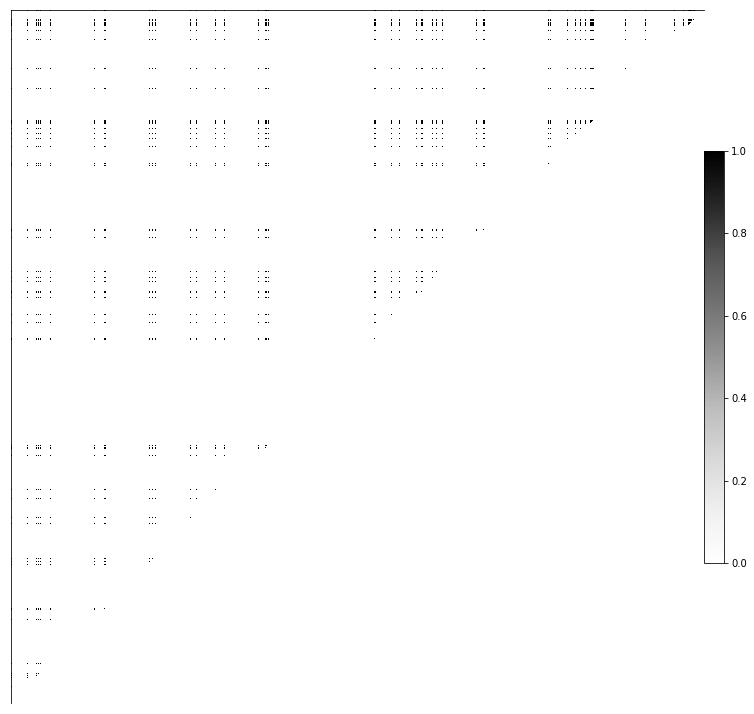

In [122]:
%matplotlib inline  

allel.plot_pairwise_ld(r_new_df_obs, colorbar=True, ax=None, imshow_kwargs=None)


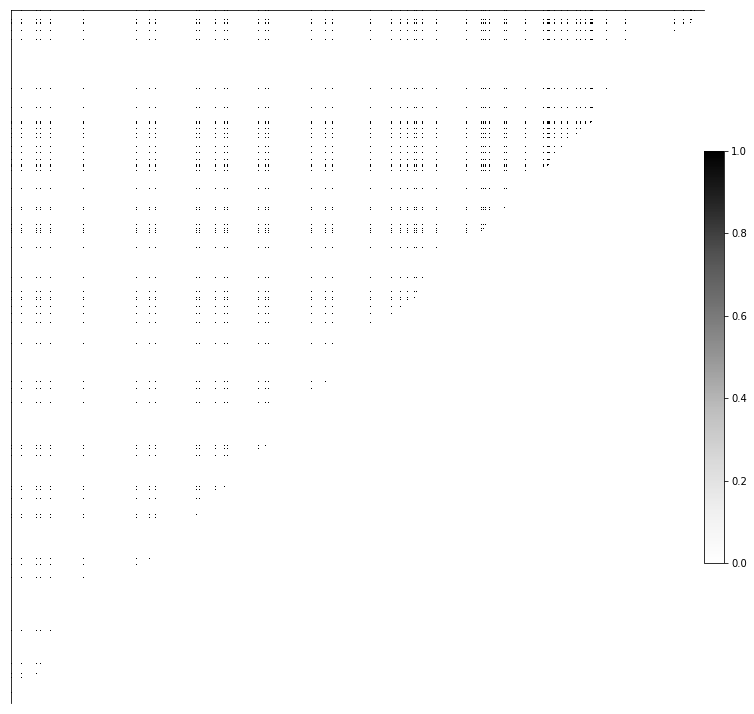

In [123]:
allel.plot_pairwise_ld(r_y_pred, colorbar=True, ax=None, imshow_kwargs=None)


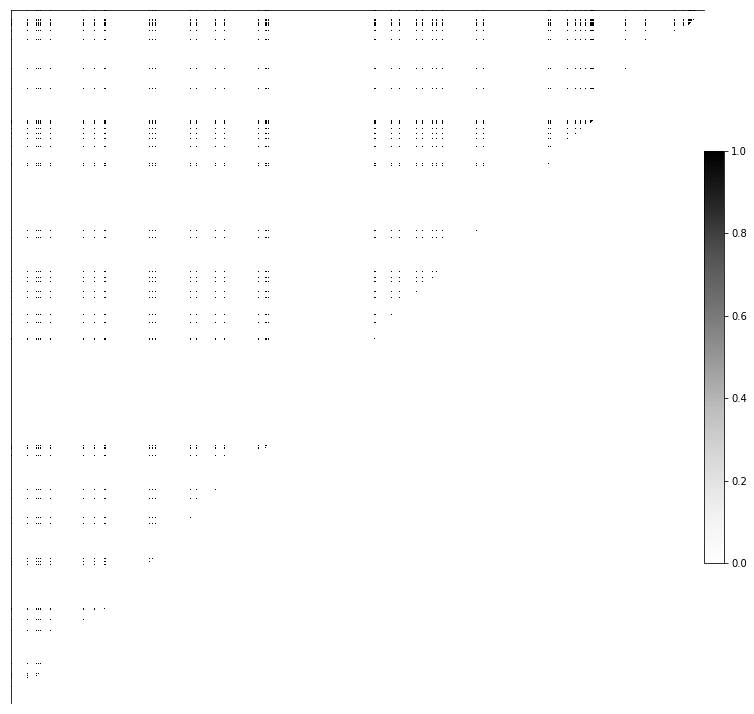

In [124]:
allel.plot_pairwise_ld(r_new_df_minimac4, colorbar=True, ax=None, imshow_kwargs=None)
